In [1]:
import numpy as np
import h5py

from utils.angles import bit2deg, deg2bit
from utils.losses import maad_from_deg

Using TensorFlow backend.


In [2]:
dbpath = '../data/pascal3d.h5'

pascal_db = h5py.File(dbpath, 'r')

train_images = pascal_db['train/aeroplane/images']
train_azimuth = pascal_db['train/aeroplane/labels'][:, 1]
train_azimuth_bit = deg2bit(train_azimuth)

val_images = pascal_db['validation/aeroplane/images']
val_azimuth = pascal_db['train/aeroplane/labels'][:, 1]
val_azimuth_bit = deg2bit(val_azimuth)

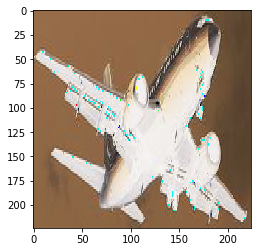

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(train_images[90])

In [11]:
n_train_images, image_height, image_width, n_channels = train_images.shape

In [12]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate

from models import vgg

Using TensorFlow backend.


In [34]:
def biternion_vgg(image_height, image_width, n_channels, name='biternion_vgg'):

    img = Input(shape=[image_height, image_width, n_channels], name='input_image')

    vgg_img = vgg.vgg_model(final_layer=False,
                            image_height=image_height,
                            image_width=image_width,
                            n_channels=n_channels)(img)

    angle = Lambda(lambda x: K.l2_normalize(x, axis=1), name='angle')(Dense(2)(vgg_img))

    model = Model(img, angle, name=name)
    
    model.compile(optimizer='Adam', loss='mse')
    
    return model

In [35]:
azimuth_model = biternion_vgg(image_height, image_width, n_channels)

In [31]:
azimuth_model.fit?

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

ckpt_path = '../logs/azimuth_model.ckpt'

early_stop_cb = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
model_ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

azimuth_model.fit(train_images, train_azimuth_bit,
                  validation_split=0.1,
                  epochs=10,
                  callbacks=[early_stop_cb, model_ckpt])

azimuth_model.load_weights(ckpt_path)

Train on 768 samples, validate on 86 samples
Epoch 1/10
768/768 [==============================] - 723s - loss: 0.8868 - val_loss: 0.9171
Epoch 2/10
768/768 [==============================] - 716s - loss: 0.8475 - val_loss: 0.9020
Epoch 3/10
768/768 [==============================] - 718s - loss: 0.8032 - val_loss: 0.8073
Epoch 4/10
640/768 [========================>.....] - ETA: 115s - loss: 0.6935

In [149]:
yaw_model.load_weights(ckpt_path)

In [155]:
val_yaw_preds = yaw_model.predict([validation_data['img'], validation_data['hpose']])
val_yaw_preds_degs = bit2deg(val_yaw_preds)

# val_pitch_preds_degs = bit2deg(val_preds[:, 2:])

In [157]:
val_yaw_preds_degs

array([ 109.7618103 ,   58.22323608,  110.92883301, ...,  142.97433472,
        133.8727417 ,  152.17456055], dtype=float32)

In [158]:
validation_data['yaw_deg']

array([ 162.60485937,   51.45169118,  166.75862016, ...,  140.93112824,
        126.81633207,  154.52741986])

In [111]:
mean_pitch_preds = np.ones(validation_data['pitch_deg'].shape[0])*np.mean(validation_data['pitch_deg'])
mean_yaw_preds = np.ones(validation_data['yaw_deg'].shape[0])*np.mean(validation_data['yaw_deg'])

In [160]:
mean_yaw_preds

array([ 93.90927926,  93.90927926,  93.90927926, ...,  93.90927926,
        93.90927926,  93.90927926])

In [161]:
np.mean(maad_from_deg(val_yaw_preds_degs, validation_data['yaw_deg']))

24.444834145743176

In [144]:
np.mean(maad_from_deg(val_pitch_preds_degs, validation_data['pitch_deg']))

3.7269034109068873